<div align = "center">

# **Severidad**

</div>

## Librerias

In [263]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [264]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [265]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,101517338,2,2410,8014069,13,4007034.6
2,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41_63,197695502,2,3862,2204046,22,1102023.2
3,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19_41,180459141,4,4223,6450375,23,1612593.7
4,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41_63,121930553,2,3077,4238816,16,2119408.0
5,1993_1999,Otros,Otros,Otros,Livianos,Particular,F,41_63,79750398,2,1099,1208679,6,604339.6
6,1993_1999,Otros,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,338559951,2,6132,8213167,35,4106583.6


In [266]:
head(sort(unique(data$valor)))

[1] 26243838 42129168 44872643 55760441 64603955 66435724

In [267]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2007_2013 
Variable: Color - Categoría de referencia: Otros 
Variable: Carroceria - Categoría de referencia: SEDAN 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Edad - Categoría de referencia: 41_63 


'data.frame':	178 obs. of  14 variables:
 $ Modelo          : Factor w/ 3 levels "2007_2013","1993_1999",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Color           : Factor w/ 4 levels "Otros","AMARILLO",..: 3 3 3 3 1 1 1 1 1 1 ...
 $ Carroceria      : Factor w/ 4 levels "SEDAN","CABINADO",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ CLASE_FASECOLDA : Factor w/ 4 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 4 levels "Particular","Oficial",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Sexo_Aseg       : Factor w/ 3 levels "M","F","No_Binarie": 2 2 1 1 2 2 2 2 1 1 ...
 $ Edad            : Factor w/ 4 levels "41_63","19_41",..: 2 1 2 1 1 2 1 4 2 4 ...
 $ valor           : num  1.02e+08 1.98e+08 1.80e+08 1.22e+08 7.98e+07 ...
 $ n_siniestros    : int  2 2 4 2 2 2 6 4 4 2 ...
 $ exposicion_total: int  2410 3862 4223 3077 1099 6132 8985 3664 6334 4361 ...
 $ suma_pagos      : num  8014069 2204046 64

In [268]:
  summary(data$valor)           # Buscar valores <= 0
  summary(data$n_siniestros)    # Buscar weights problemáticos
  summary(data$suma_pagos)      # Variable respuesta

  # Verificar si hay infinitos en log(valor)
  any(is.infinite(log(data$valor)))
  any(is.na(log(data$valor)))

  # Filtrar observaciones problemáticas antes del hnp()
  data <- data[data$valor > 0 & data$n_siniestros > 0 &
                     is.finite(log(data$valor)), ]

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.624e+07 2.930e+08 6.913e+08 1.444e+09 1.809e+09 1.141e+10 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   5.247   6.000  39.000 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   114915   2965280   6455237  14091604  14368452 121532938 

[1] FALSE

[1] FALSE

# **Gamma log**

## Seleccion de variables

In [269]:
names(data)

[1] "Modelo"           "Color"            "Carroceria"       "CLASE_FASECOLDA" 
 [5] "TIPO_VEHICULO"    "SERVICIO"         "Sexo_Aseg"        "Edad"            
 [9] "valor"            "n_siniestros"     "exposicion_total" "suma_pagos"      
[13] "n_observaciones"  "severidad_media"

In [270]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  suma_pagos ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + offset(log(exposicion_total)),
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_gamma <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

summary(modelo_severidad_gamma)

Start:  AIC=33194.97
suma_pagos ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + offset(log(exposicion_total))




Call:
glm(formula = suma_pagos ~ log(valor) + Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Edad + offset(log(exposicion_total)), family = Gamma(link = "log"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3236  -1.3354  -0.4412   0.4611   4.4000  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   13.43798    1.78759   7.517  4.1e-12 ***
log(valor)                    -0.27548    0.07861  -3.504 0.000598 ***
Modelo1993_1999               -0.85181    0.37449  -2.275 0.024292 *  
Modelo2000_2006               -0.12626    0.21582  -0.585 0.559375    
ColorAMARILLO                 -0.33388    0.65981  -0.506 0.613555    
ColorBLANCO                    0.02621    0.18974   0.138 0.890301    
ColorPLATA                    -0.01980    0.15380  -0.129 0.897733    
CarroceriaCABINADO            -0.36631    0.35462

Como hay significancia en log(valor), Modelo1993_1999, CarroceriaHATCHBACK, Edad19_41 vamos a dejar log(valor), Modelo, Carroceria, Edad y Sexo nada mas.

In [271]:
modelo_severidad_gamma <- glm(
  suma_pagos ~ log(valor) + Modelo + Carroceria + Sexo_Aseg + Edad + offset(log(exposicion_total)),
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)
summary(modelo_severidad_gamma)


Call:
glm(formula = suma_pagos ~ log(valor) + Modelo + Carroceria + 
    Sexo_Aseg + Edad + offset(log(exposicion_total)), family = Gamma(link = "log"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3408  -1.3082  -0.6628   0.5520   4.2828  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         11.69724    1.27498   9.174  < 2e-16 ***
log(valor)          -0.19778    0.05688  -3.477 0.000647 ***
Modelo1993_1999     -0.59772    0.33829  -1.767 0.079083 .  
Modelo2000_2006      0.05853    0.18604   0.315 0.753455    
CarroceriaCABINADO  -0.24447    0.18322  -1.334 0.183919    
CarroceriaHATCHBACK  0.20610    0.12458   1.654 0.099932 .  
CarroceriaOtros      0.20812    0.18952   1.098 0.273709    
Sexo_AsegF          -0.21301    0.11167  -1.907 0.058191 .  
Sexo_AsegNo_Binarie -0.42193    0.21617  -1.952 0.052637 .  
Edad19_41            0.27445    0.12682   2.164 0.031889 *  
Edad

Gamma model 


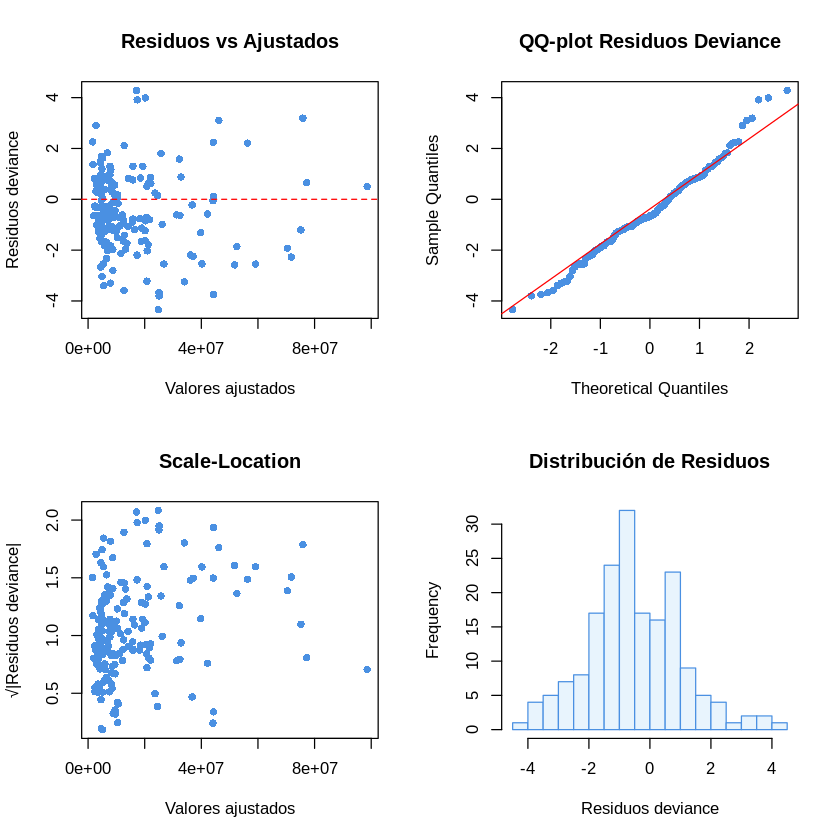

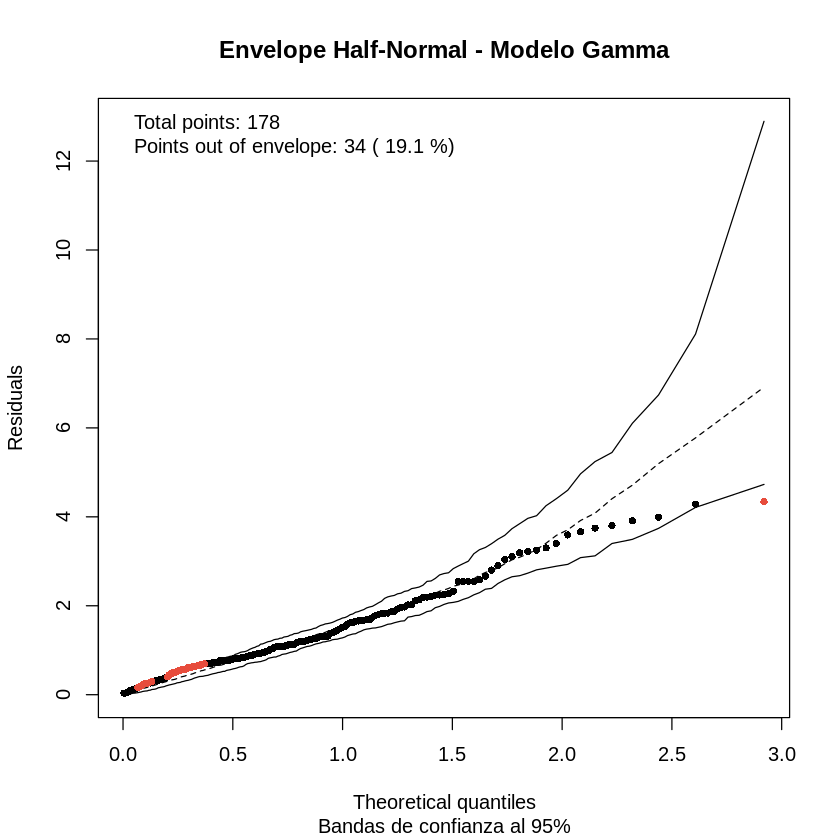

In [272]:
# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_gamma, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_gamma, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_gamma)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo Gamma
set.seed(123)  # Para reproducibilidad

  envelope_gamma <- hnp(modelo_severidad_gamma, 
                      sim = 99,           # Número de simulaciones
                      conf = 0.95,        # Nivel de confianza
                      halfnormal = TRUE,  # Gráfico half-normal
                      scale = TRUE,       # Escalar residuos
                      plot.sim = TRUE,    # Mostrar simulaciones
                      verb.sim = FALSE,   # Sin output verbose
                      how.many.out = TRUE,# Contar outliers
                      print.on = TRUE,    # Imprimir estadísticas
                      paint.out = TRUE,   # Colorear outliers
                      col.paint.out = "#E74C3C",
                      pch = 16,
                      cex = 0.8)


# Personalizar el gráfico
title("Envelope Half-Normal - Modelo Gamma", 
      sub = "Bandas de confianza al 95%")

## **Lognormal**

In [273]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  log(suma_pagos) ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + offset(log(exposicion_total)),
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  log(suma_pagos) ~ 1,
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_lognormal <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

summary(modelo_severidad_lognormal)

Start:  AIC=516.04
log(suma_pagos) ~ log(valor) + Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Edad + offset(log(exposicion_total))




Call:
glm(formula = log(suma_pagos) ~ log(valor) + Modelo + Color + 
    Carroceria + CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + 
    Sexo_Aseg + Edad + offset(log(exposicion_total)), family = gaussian(link = "identity"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.4736  -1.0879  -0.0246   0.9335   4.7844  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   11.52781    2.07519   5.555 1.17e-07 ***
log(valor)                    -0.19552    0.09126  -2.142   0.0337 *  
Modelo1993_1999               -0.48305    0.43474  -1.111   0.2682    
Modelo2000_2006               -0.29834    0.25054  -1.191   0.2355    
ColorAMARILLO                 -0.62594    0.76597  -0.817   0.4151    
ColorBLANCO                   -0.22551    0.22027  -1.024   0.3075    
ColorPLATA                     0.02704    0.17854   0.151   0.8798    
CarroceriaCABINADO            -0.102

Solo queda log(valor), Tipo_Vehiculo, y Edad

In [274]:
modelo_severidad_lognormal <- glm(
  log(suma_pagos) ~ log(valor) + TIPO_VEHICULO + Sexo_Aseg + Edad + offset(log(exposicion_total)),
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)
summary(modelo_severidad_lognormal)


Call:
glm(formula = log(suma_pagos) ~ log(valor) + TIPO_VEHICULO + 
    Sexo_Aseg + Edad + offset(log(exposicion_total)), family = gaussian(link = "identity"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2485  -1.2701  -0.0823   0.8664   4.8448  

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           9.18289    1.09032   8.422 1.49e-14 ***
log(valor)           -0.09000    0.04968  -1.811  0.07184 .  
TIPO_VEHICULOPesados  0.80971    0.35805   2.261  0.02500 *  
Sexo_AsegF           -0.19961    0.12824  -1.556  0.12145    
Sexo_AsegNo_Binarie  -0.67366    0.23841  -2.826  0.00529 ** 
Edad19_41             0.29340    0.14591   2.011  0.04592 *  
Edad63_85             0.31668    0.27018   1.172  0.24279    
EdadOtros             0.13461    0.19382   0.695  0.48831    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family 

Gaussian model (glm object) 


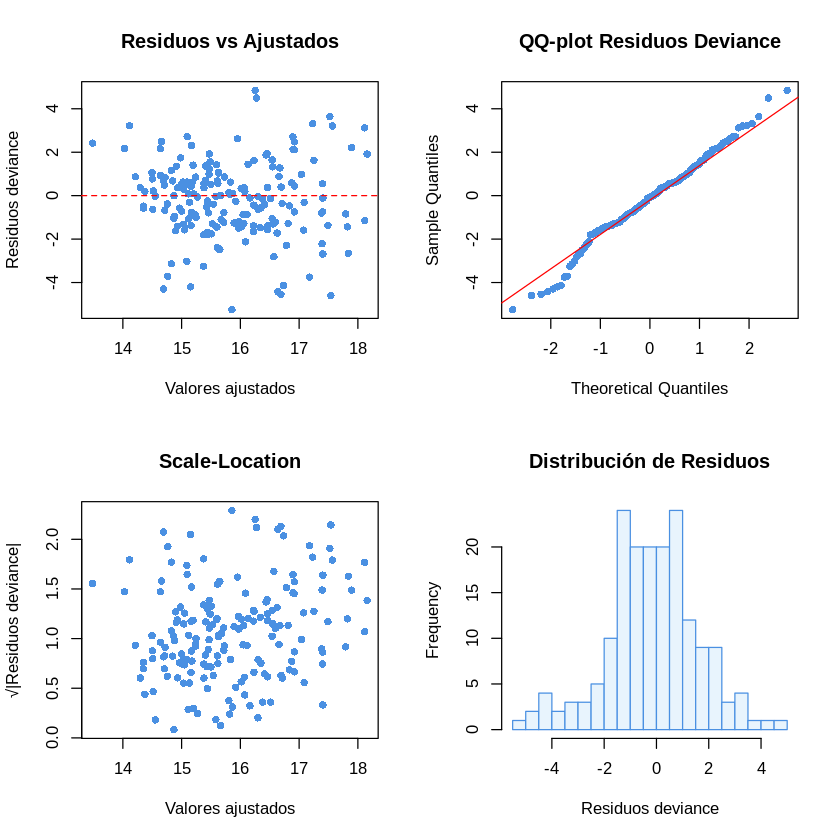

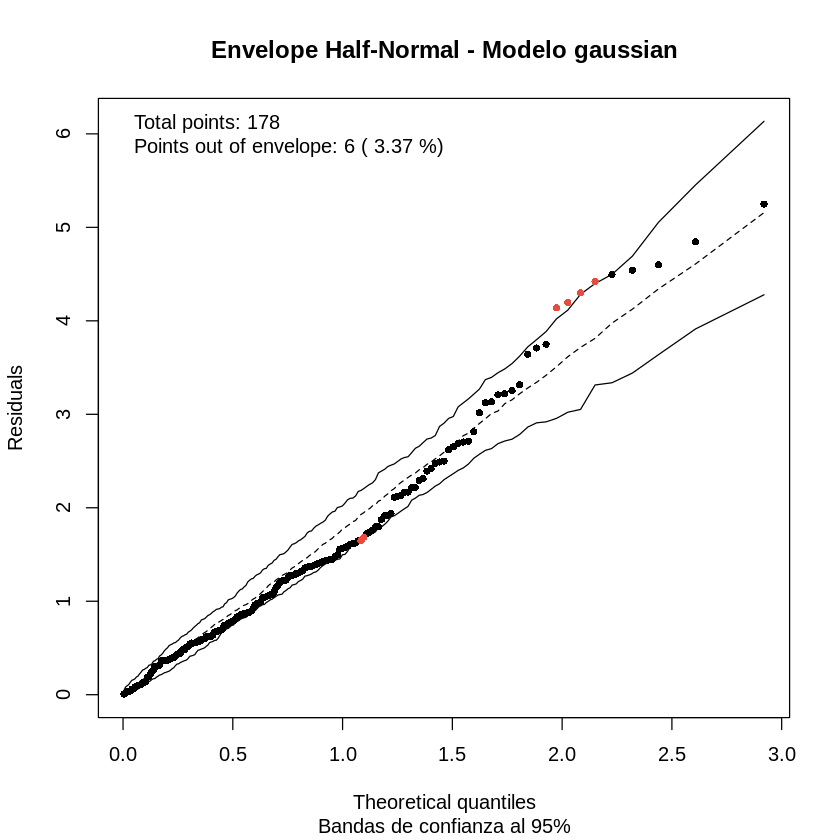

In [275]:
# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_lognormal, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_lognormal, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_lognormal)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo gaussian
set.seed(123)  # Para reproducibilidad

envelope_gaussian <- hnp(modelo_severidad_lognormal, 
                      sim = 99,           # Número de simulaciones
                      conf = 0.95,        # Nivel de confianza
                      halfnormal = TRUE,  # Gráfico half-normal
                      scale = TRUE,       # Escalar residuos
                      plot.sim = TRUE,    # Mostrar simulaciones
                      verb.sim = FALSE,   # Sin output verbose
                      how.many.out = TRUE,# Contar outliers
                      print.on = TRUE,    # Imprimir estadísticas
                      paint.out = TRUE,   # Colorear outliers
                      col.paint.out = "#E74C3C",
                      pch = 16,
                      cex = 0.8)

# Personalizar el gráfico
title("Envelope Half-Normal - Modelo gaussian", 
      sub = "Bandas de confianza al 95%")

## Exportando

In [276]:
  # Guardar el modelo de severidad final
  saveRDS(modelo_severidad_gamma, file = "../models/modelo_severidad_gamma.rds")

  # Opcional: También guardar información adicional del modelo
  modelo_info <- list(
    modelo = modelo_severidad_gamma,
    aic = AIC(modelo_severidad_gamma),
    formula = formula(modelo_severidad_gamma),
    family = "Gamma",  # "Gamma" o "Log-Normal"
    fecha_entrenamiento = Sys.Date()
  )

  saveRDS(modelo_info, file = "../models/modelo_severidad_gamma_completo.rds")

In [277]:
  # Guardar el modelo de severidad final
  saveRDS(modelo_severidad_lognormal, file = "../models/modelo_severidad_lognormal.rds")

  # Opcional: También guardar información adicional del modelo
  modelo_info <- list(
    modelo = modelo_severidad_lognormal,
    aic = AIC(modelo_severidad_lognormal),
    formula = formula(modelo_severidad_lognormal),
    family = "lognormal",  # "lognormal" o "Log-Normal"
    fecha_entrenamiento = Sys.Date()
  )

  saveRDS(modelo_info, file = "../models/modelo_severidad_lognormal_completo.rds")